In [ ]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone --single-branch https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import IPython
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as opt
from torch.distributions.uniform import Uniform
from torch.distributions.normal import Normal
from torch.distributions.beta import Beta
from tqdm._tqdm_notebook import tqdm

import copy

from scipy.stats import norm
from scipy.optimize import bisect
from tqdm import trange, tqdm_notebook

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
from dul_2021.utils.hw3_utils import *

In [14]:
class MaskedConv(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.register_buffer('mask', torch.zeros_like(self.weight))
        self.set_mask()
    
    def forward(self, x):
        return F.conv2d(x, self.mask * self.weight, bias=self.bias, stride=self.stride, padding=self.padding)

    def set_mask(self):
        raise NotImplementedError()

class ConvA(MaskedConv):
    def set_mask(self):
        h, w = self.kernel_size
        self.mask[:, :, h // 2, : w // 2] = 1
        self.mask[:, :, :h // 2] = 1
    
class ConvB(MaskedConv):
    def set_mask(self):
        h, w = self.kernel_size
        self.mask[:, :, h // 2, : w // 2 + 1] = 1
        self.mask[:, :, :h // 2] = 1


class ResBlock(nn.Module):
    def __init__(self, in_ch, cf=120):
        super().__init__()

        self.block = nn.Sequential(
            nn.ReLU(), nn.Conv2d(in_ch, cf, 1),
            nn.ReLU(), ConvB(cf, cf, 7, 1, 3),
            nn.ReLU(), nn.Conv2d(cf, in_ch, 1),
        )
    def forward(self, x):
        out = self.block(x)
        out += x
        return out


class LayerNorm(nn.LayerNorm):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)

  def forward(self, x):
    x = x.permute(0, 2, 3, 1).contiguous()
    x = super().forward(x)
    return x.permute(0, 3, 1, 2).contiguous()

In [15]:
class PixelCNN(nn.Module):
    def __init__(self, input_shape, k=2, cf=120):
        super().__init__()
        self.input_shape = input_shape # (1, 20, 20)
        self.k = k # количество компонент в смеси

        layers = [ConvA(input_shape[0], cf, 7, 1, 3), LayerNorm(cf), nn.ReLU()]
        layers.extend([ResBlock(cf, cf), LayerNorm(cf)] * 4)
        layers.extend([nn.ReLU(), ConvB(cf, cf, 1),
                       nn.ReLU(), ConvB(cf, k * 3, 1)])
        self.model = nn.Sequential(*layers)

        self.bdist = Uniform(torch.Tensor([0.]).to(device), torch.Tensor([1.]).to(device))
        self.bdist_sample = Uniform(0., 1.)
        
    def forward(self, x):
        bs = x.shape[0]
        out = (x.float() - 0.5) / 0.5
        out = self.model(x)
        out = out.view(bs, self.k * 3, *self.input_shape)
        return out

    def nll(self, x):
        return - self.log_prob(x).mean()

    def log_prob(self, x):
        out = self.forward(x)

        mu, log_s, log_w = torch.chunk(out, 3, dim=1)

        w = F.softmax(log_w, dim=1)

        mix_dist = Normal(mu, log_s.exp())

        xr = x.unsqueeze(1).repeat(1, self.k, 1, 1, 1)

        z = (mix_dist.cdf(xr) * w).sum(dim=1)

        log_det = (mix_dist.log_prob(xr).exp() * w).sum(dim=1).log()

        return self.bdist.log_prob(z).to(device) + log_det

    # для дискретизации надо переписать test и fit методы (будем добавлять шум)
    def test(self, testloader):
        with torch.no_grad():
            loss = 0
            tc = 0
            for batch in testloader:
                batch = batch.to(device)
                noise = self.bdist.rsample(batch.shape).squeeze(-1).to(device) / 2
                batch += noise
                batch /= 2
                loss += self.nll(batch.float()) * batch.shape[0]
                tc += batch.shape[0]
            return loss / tc
                
    def fit(self, train_data, test_data, num_epochs=20, lr=1e-3, batch_size=128):
        trainloader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
        testloader = data.DataLoader(test_data, batch_size=batch_size)

        train_loss = []
        test_loss = []
        optim = opt.Adam(self.parameters(), lr=lr)
        test_loss.append(self.test(testloader))
        self.to(device)

        for epoch in tqdm(range(num_epochs)):
            for batch in trainloader:
                batch = batch.to(device)
                noise = self.bdist.rsample(batch.shape).squeeze(-1).to(device) / 2
                batch += noise
                batch /= 2
                loss = self.nll(batch.float())
                optim.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.parameters(), 1)
                optim.step()

                train_loss.append(loss.cpu().data)
            test_loss_val = self.test(testloader)
            test_loss.append(test_loss_val)
            print(f'Epoch {epoch + 1}:', test_loss_val.item())
        return train_loss, test_loss

    def inverse_cdf(self, z, dist, w):
        xs = []
        for i in range(len(z)):
            def f(x):
                xr = torch.Tensor([x]).unsqueeze(1).repeat(1, self.k)
                return w[i] @ dist.cdf(xr)[i] - z[i]
            x = bisect(f, -20, 20)
            xs.append(x)
        return torch.Tensor(xs)

    def sample(self, n=100):
        self.eval()
        with torch.no_grad():
            samples = torch.zeros(n, *self.input_shape).to(device)
            for i in range(self.input_shape[1]):
                for j in range(self.input_shape[2]):
                    mu, log_s, log_w = torch.chunk(self(samples).cpu().detach(), 3, dim=1)
                    for c in range(self.input_shape[0]):

                        mu_ = mu[:, :, c, i, j]
                        log_s_ = log_s[:, :, c, i, j]
                        log_w_ = log_w[:, :, c, i, j]
                        w_ = torch.softmax(log_w_, dim=1) # [100, k]
                        
                        z = self.bdist_sample.sample((n,))
                        dist = Normal(mu_, log_s_.exp())
                        samples[:, c, i, j] = self.inverse_cdf(z, dist, w_)

            return samples.cpu().detach().numpy().transpose(0, 2, 3, 1)


# Question 1: Autoregressive Flows for Images

Adapt your PixelCNN implementation from Homework 2 and use it as an autoregressive flow model on the black-and-white shapes dataset. Using the base architecture from Homework 2 1(a), output a mixture of logistics or gaussians (instead of logits), whose CDF we will use as our flow for each dimension of x. 

Remember: you must dequantize the data and scale it between 0 and 1 for the autoregressive flow to have stable training. 

**You will provide these deliverables**

1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. **Make sure to account for any rescaling you do in your nats/dim.**
2.   Report the final test set performance of your final model
3. 100 samples from your autoregressive flow. Our plotting code will show your samples, with and without clipping and flooring (to remove the quantization). 


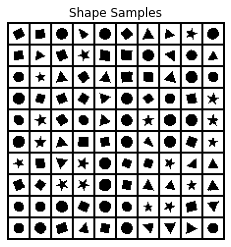

In [7]:
visualize_q1_data()

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [18]:
def q1(train_data, test_data):
  """
  train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  test_data: A (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  H = W = 20
  Note that you should dequantize your train and test data, your dequantized pixels should all lie in [0,1]

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 1) of samples with values in [0, 1], where [0,0.5] represents a black pixel
      and [0.5,1] represents a white pixel. We will show your samples with and without noise. 
  """
  
  train_data = torch.Tensor(train_data).permute(0, 3, 1, 2)
  test_data = torch.Tensor(test_data).permute(0, 3, 1, 2)
  input_size = train_data[0].shape
  ARFM = PixelCNN(input_size).to(device)

  train_losses, test_losses = ARFM.fit(train_data, test_data, 
                                       **dict(num_epochs=10, lr=1e-3))
  samples = ARFM.sample(100)

  return train_losses, test_losses, samples

### Results

Once you've implemented `q1`, execute the cells below to visualize and save your results



  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1: -0.6761787533760071
Epoch 2: -0.7164161205291748
Epoch 3: -0.9656206965446472
Epoch 4: -1.0175060033798218
Epoch 5: -1.04345703125
Epoch 6: -1.0379999876022339
Epoch 7: -0.9936288595199585
Epoch 8: -1.0985829830169678
Epoch 9: -1.1100971698760986
Epoch 10: -1.1041693687438965
Epoch 11: -1.1313563585281372
Epoch 12: -1.135892391204834
Epoch 13: -1.093247652053833
Epoch 14: -1.1446630954742432
Epoch 15: -1.1518442630767822
Epoch 16: -1.154291033744812
Epoch 17: -1.1550981998443604
Epoch 18: -1.1581065654754639
Epoch 19: -1.1583019495010376
Epoch 20: -1.1572329998016357
Final Test Loss: -1.1572


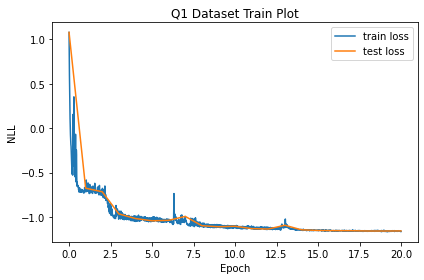

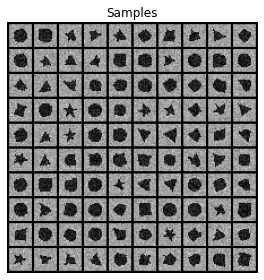

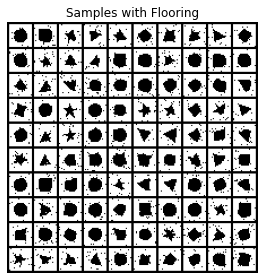

In [ ]:
q1_save_results(q1)